<a href="https://colab.research.google.com/github/kubohenrique/PROJETOS_EDS/blob/main/PROJETO_ANIMAL_CENTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Séries Temporais com o Prophet

Neste projeto, trabalharemos com séries temporais (*time series*) e a ferramenta ***Prophet***. Especificamente, faremos a previsão relacionada ao desfecho (*outcomes*) de animais em um abrigo

Antes de entrar no projeto em si, vamos conhecer o Prophet e o motivo dele ser tão poderoso para lidar com dados temporais.

## Prophet e Séries Temporais

Fazer boas previsões com dados temporais é uma tarefa altamente complexa. Dada a complexidade dos modelos estatísticos, *time series* representam um desafio para engenheiros de *machine learning*, estatísticos e economistas.

Tentar implementar um modelo sem usar nenhum *framework*, implica entender profundamente uma teoria que não é trivial e que exige um certo grau de especialização.

***Prophet***é um *framework* de forecasting* para séries temporais, disponibilizado como projeto *open source* pelo **Facebook**. Implementado em Python e R, é capaz de realizar previsões automatizadas e rápidas.

<p align="center"><img src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/prophet.png" height="300px"></p>

Como nem todos os problemas de *time series* podem ser resolvidos da mesma maneira - e o Prophet foi desenvolvido pensando-se nos problemas internos do Facebook -, é possível que cientistas e analistas de dados otimizem parâmetros do *framework*.

### Modelo Preditivo do Prophet

Como dissemos acima, o Prophet foi feito para solucionar problemas do Facebook. Ou seja, é muito forte para lidar com problemas que tenham características como:

* Dados coletados por um longo período (meses ou anos), e que possuam o maior detalhamento histórico possível.
* Sazonalidades fortes e destacadas.
* Feriados ou datas especiais conhecidas *a priori*.
* Tendência de crescimento não linear, que se aproxima de um limite.

Propeht usa um modelo de séries temporais decomposto, com três componentes principais: tendência, sazonalidade e feriados:

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

onde:

* $g(t)$ é a tendência, que modela as mudanças não-periódicas no valor da série temporal;
* $s(t)$ representa as mudanças periódicas (como sazonalidade semanal, anual, etc);
* $h(t)$ representa os efeitos dos feriados; e
* $\varepsilon_t$ é o erro, as mudanças que não são capturadas pelo modelo (assume-se esse como tendo uma distribuição normal).

Lembrando, os parâmetros que estão definidos como *standard* atendem bem a maioria dos casos. No entanto, caso não tenham um *fit* adequado ao seu problema, esses podem ser ajustados manualmente.


## O Problema de um Abrigo de Animais

O centro de animais de Austin Texas abriga milhares de animais por ano (independente de raça, idade, e estado de saúde), além de se envolver em outros serviços envolvendo proteção de animais.

O objetivo principal deles é de encontrar um novo lar para todos os animais acolhidos. Apesar disso, nem todos os animais conseguem um novo lar, e muitos acabam sendo sacrificados. A meta do Austin Animal Center é de não sacrificar mais que 10% dos animais acolhidos.

Neste projeto, iremos analisar as saídas com vida desses animais. Com essa análise, espera-se que sejamos capazes de identificar um padrão de adoção.

Mais que identificar um padrão, espera-se fazer previsões futuras em relação ao número de saídado Austin Animal Center, visando:

1. Planejar compras de insumos (remédios, comida, etc);
2. Contratação de funcionários e colaboradores; e
3. Fazer campanhas visando otimizar a adoção de animais.

### Aquisição dos Dados

Os dados foram disponibilizados pelo [Austin Animal Center](http://www.austintexas.gov/content/austin-animal-center) e podem ser baixados diretamente no [City of Austin Open Data Portal](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238).

O *dataset* usado neste *notebook* foi atualizado em 30 de abril de 2020 e contém **117K linhas** e **12 colunas**, onde  

In [1]:
# importar as bibliotecas necessárias
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# configurar a visualização
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# importar os dados para um DataFrame
df = pd.read_csv("https://github.com/carlosfab/escola-data-science/blob/master/datasets/shelter_animal_outcomes.csv?raw=true")

# converter a coluna DateTime para o formato conveniente
df.DateTime = pd.to_datetime(df.DateTime)

# ver as primeiras 5 entradas
df.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,2016-02-13 17:59:00,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
3,A674754,NaN,2014-03-18 11:47:00,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
4,A689724,*Donatello,2014-10-18 18:52:00,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black


### Análise Exploratória

FALAR SOBRE OS INSIGHTS E SE QUISER, FAZER UM DICIONÁRIO DE VARIÁVEIS E UMA ANÁLISE EXPLORATÓRIA MAIS APROFUNDADA

In [3]:
# ver o resumo das principais informações estatísticas
df.describe()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,117416,80599,117416,117416,117416,117408,53247,117416,117413,117369,117416,117416
unique,104978,18867,96710,96710,6806,9,22,5,5,50,2568,585
top,A721033,Max,2016-04-18 00:00:00,04/18/2016 12:00:00 AM,04/21/2014,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,33,525,39,39,117,51722,29119,66777,41234,21150,30746,12337
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2020-04-30 18:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Por uma análise preliminar, podemos ver que cachorros machos e castrados são o grupo de animais mais acolhidos pelo abrigo.

In [4]:
df['Animal Type'].value_counts()

Dog          66777
Cat          43949
Other         6130
Bird           542
Livestock       18
Name: Animal Type, dtype: int64

In [5]:
# ver um resumo dos tipos de variáveis e valores não-nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117416 entries, 0 to 117415
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         117416 non-null  object        
 1   Name              80599 non-null   object        
 2   DateTime          117416 non-null  datetime64[ns]
 3   MonthYear         117416 non-null  object        
 4   Date of Birth     117416 non-null  object        
 5   Outcome Type      117408 non-null  object        
 6   Outcome Subtype   53247 non-null   object        
 7   Animal Type       117416 non-null  object        
 8   Sex upon Outcome  117413 non-null  object        
 9   Age upon Outcome  117369 non-null  object        
 10  Breed             117416 non-null  object        
 11  Color             117416 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 10.7+ MB


In [6]:
# verificar se há dados ausentes
df.isnull().sum()

Animal ID               0
Name                36817
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            8
Outcome Subtype     64169
Animal Type             0
Sex upon Outcome        3
Age upon Outcome       47
Breed                   0
Color                   0
dtype: int64

Para os dados relevantes, quase não há dados faltantes, dessa forma optei por não tratar os dados faltantes.

In [7]:
# ver os tipos de outcomes possíveis
df['Outcome Type'].value_counts()

Adoption           51722
Transfer           34892
Return to Owner    20636
Euthanasia          7890
Died                1075
Rto-Adopt            611
Disposal             495
Missing               67
Relocate              20
Name: Outcome Type, dtype: int64

In [8]:
# Ver apenas os outcomes de adoção e retorno aos donos
adoptions_df = df[(df['Outcome Type'] == 'Adoption')]
adoptions_df['outcomeCount'] = 1

adoptions_df = adoptions_df[['DateTime', 'outcomeCount']]
adoptions_df = adoptions_df.set_index('DateTime').sort_index()
adoptions_df.head()

,outcomeCount
DateTime,
2013-10-01 09:31:00,1
2013-10-01 11:42:00,1
2013-10-01 11:53:00,1
2013-10-01 11:53:00,1
2013-10-01 15:47:00,1


In [9]:
# ver as datas mínimas e máximas
adoptions_df.index.min(), adoptions_df.index.max()

(Timestamp('2013-10-01 09:31:00'), Timestamp('2020-04-30 14:41:00'))

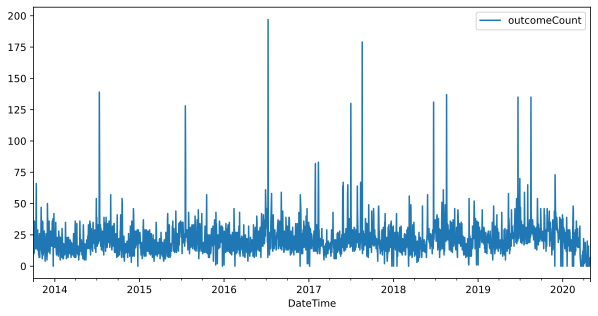

In [10]:
# plotar gráfico diário
fig, ax = plt.subplots(figsize=(10,5))
adoptions_df.resample('D').sum().plot(ax=ax)
plt.show()

Como era de se esperar, é difícil prever, ou analisar adoções diárias.

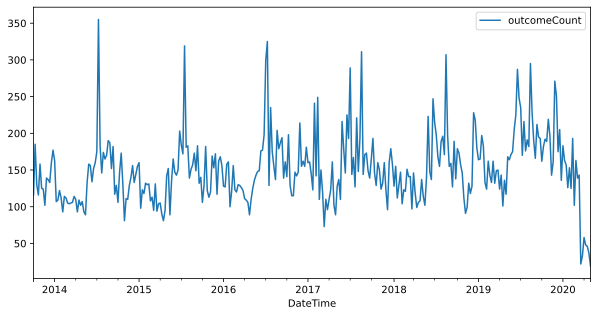

In [11]:
# plotar gráfico semanal
fig, ax = plt.subplots(figsize=(10,5))
adoptions_df.resample('W').sum().plot(ax=ax)
plt.show()

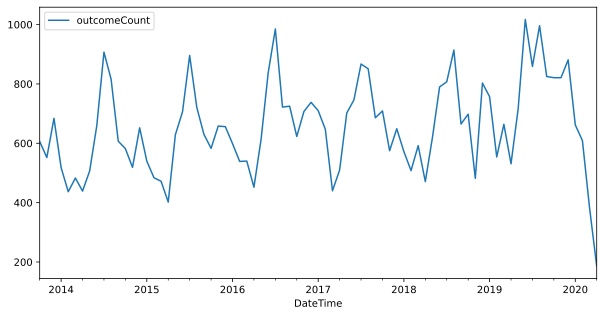

In [12]:
# plotar gráfico Mensal
fig, ax = plt.subplots(figsize=(10,5))
adoptions_df.resample('M').sum().plot(ax=ax)
plt.show()

Pelos gráficos cheguei a conclusão de que os meses de Julho são os mais propícios 

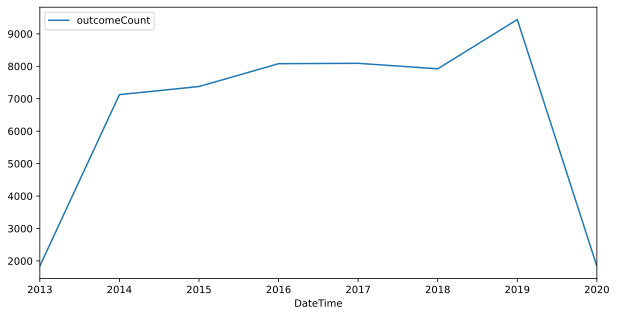

In [13]:
# plotar gráfico anual

fig, ax = plt.subplots(figsize=(10,5))
adoptions_df.resample('Y').sum().plot(ax=ax)
plt.show()

Como podemos ver pelo gráfico acima, a tendência do abrigo é de aumento no número de adoções e retorno aos donos, o ano de 2020 foi excluido pois não se contabilizou o ano todo.

### Preparar os Dados para o Prophet

Os dados de entrado para o Prophet são sempre um Dataframe com duas colunas: *ds* e *y*.
A coluna *ds* deve estar no formato padrão para o Pandas, idealmente AAAA-MM-DD para datas e AAAA-MM-DD HH:MM:SS para data com horário.
A coluna y precisa ser numérica, e representa o valor que nós desejamos prever.


In [14]:
# trabalhar com dados diários
prophet_df = adoptions_df.resample('D').sum().reset_index().rename(columns={'DateTime':'ds', 'outcomeCount':'y'})

# ver as 5 primeiras entradas
prophet_df.head()

,ds,y
0,2013-10-01,11
1,2013-10-02,16
2,2013-10-03,10
3,2013-10-04,11
4,2013-10-05,36


### Criar o Modelo de Forecasting

#### Modelo Diário

In [15]:
# instanciar e treinar o modelo
model = Prophet()
model.fit(prophet_df)

# determinar o período de dias para previsão
future = model.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


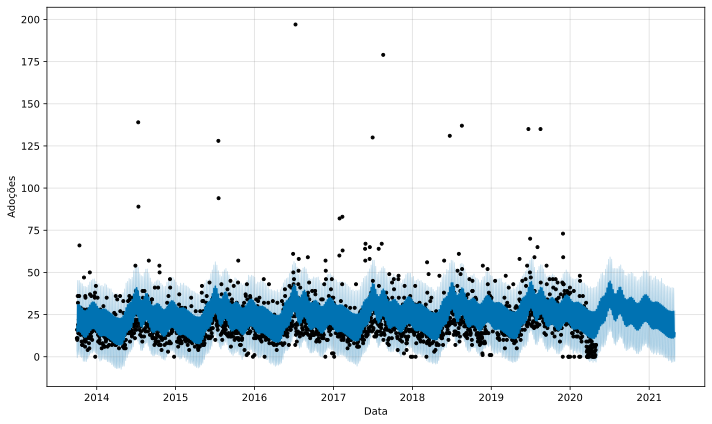

In [16]:
# visualizar o gráfico com as previsões
model.plot(forecast, xlabel='Data', ylabel='Adoções');

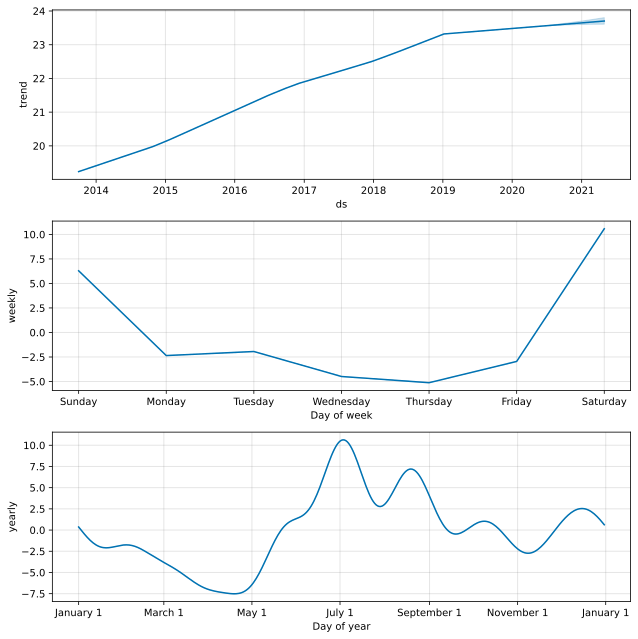

In [17]:
# separar os componentes do modelo
model.plot_components(forecast);

#### Modelo Semanal

In [18]:
# criar um modelo baseado em semanas
prophet_df2 = adoptions_df.resample('W').sum().reset_index().rename(columns={'DateTime':'ds', 'outcomeCount':'y'})

# instanciar e treinar o modelo
model2 = Prophet()
model2.fit(prophet_df2)

# determinar o período de dias para previsão
future2 = model2.make_future_dataframe(periods=52)

# realizar a previsão para o período estabelecido
forecast2 = model2.predict(future2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


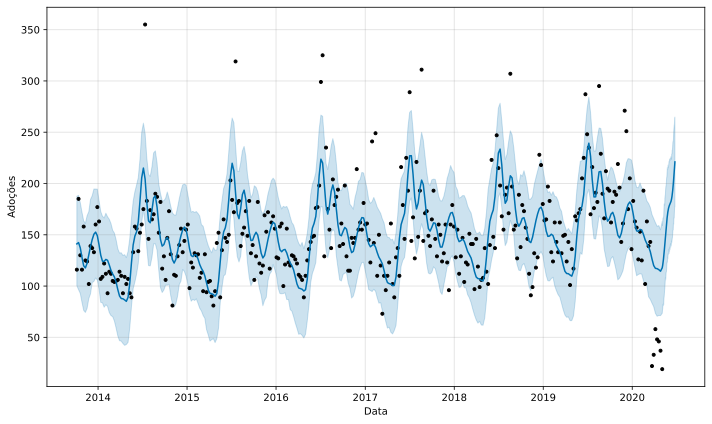

In [19]:
# visualizar o gráfico com as previsões
model2.plot(forecast2, xlabel='Data', ylabel='Adoções');

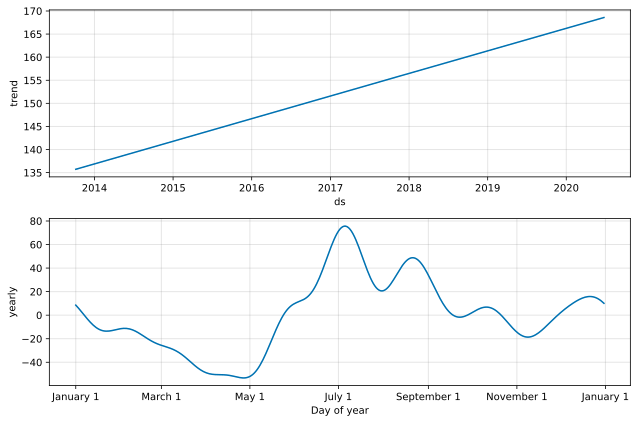

In [20]:
# separar os componentes do modelo
model2.plot_components(forecast2);

Algumas hipóteses foram confirmados:


*   **A tendencia de Adoções é de crescimento.**
*   **O mês que ocorre mais adoções é Julho.**
*   **Nos finais de semana ocorrem mais adoções.**



### Avaliação do Modelo de Séries Temporais

#### Modelo Diário

In [36]:
df_cv = cross_validation(model, horizon='365 days')
df_cv.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2016-10-30 12:00:00 and 2019-05-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-10-31,16.778579,4.491522,28.853724,16,2016-10-30 12:00:00
1,2016-11-01,16.429546,3.724200,28.109372,16,2016-10-30 12:00:00
2,2016-11-02,14.258137,1.513757,25.868480,13,2016-10-30 12:00:00
3,2016-11-03,13.602668,1.519478,25.969116,21,2016-10-30 12:00:00
4,2016-11-04,14.630016,2.580385,26.903016,26,2016-10-30 12:00:00


In [35]:
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,50 days,94.134050,9.702270,7.601494,0.333945,0.85
1,51 days,92.692468,9.627693,7.492933,0.328983,0.85
2,52 days,93.121263,9.649936,7.541034,0.326029,0.85
3,53 days,90.630581,9.520010,7.384908,0.323149,0.86
4,54 days,87.799942,9.370162,7.238220,0.313012,0.87


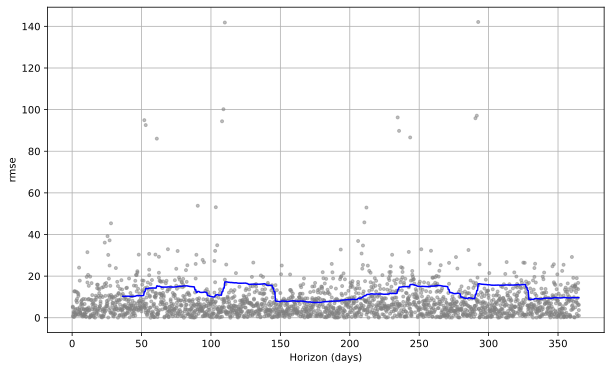

In [25]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [31]:
df_cv2 = cross_validation(model2, horizon='365 days')
print( df_cv2.head(), '\n' )

df_p2 = performance_metrics(df_cv2)
print( df_p2.head(), '\n' )

INFO:fbprophet:Making 6 forecasts with cutoffs between 2016-11-02 12:00:00 and 2019-05-04 00:00:00



          ds        yhat  yhat_lower  yhat_upper    y              cutoff
0 2016-11-06  128.017837   94.515474  162.861154  147 2016-11-02 12:00:00
1 2016-11-13  134.631583  100.187285  167.886229  142 2016-11-02 12:00:00
2 2016-11-20  145.434532  115.448712  178.804911  147 2016-11-02 12:00:00
3 2016-11-27  152.318239  119.206939  184.768624  214 2016-11-02 12:00:00
4 2016-12-04  153.960477  119.909382  186.072852  155 2016-11-02 12:00:00 

           horizon          mse       rmse  ...      mape     mdape  coverage
0 36 days 00:00:00   962.895126  31.030551  ...  0.185095  0.158810  0.741935
1 36 days 12:00:00   988.100813  31.434071  ...  0.191117  0.167425  0.741935
2 37 days 00:00:00   981.268114  31.325199  ...  0.188347  0.158810  0.741935
3 37 days 12:00:00  1131.794059  33.642147  ...  0.207776  0.167425  0.709677
4 38 days 00:00:00  1138.965616  33.748565  ...  0.209518  0.167425  0.709677

[5 rows x 7 columns] 



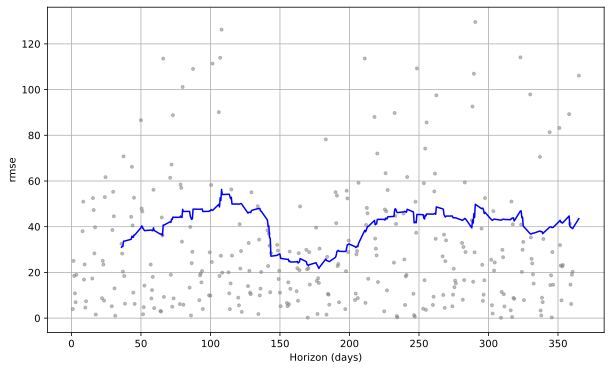

In [37]:
fig = plot_cross_validation_metric(df_cv2, metric='rmse')

Apesar de possuir algumas incertezas, o modelo de predição semanal está com uma margem de confiança melhor que o diário, o que era de se esperar pois ela diminui a variação diária das predições.